In [3]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
adata = sc.read_10x_mtx('hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols (stored within the .mtx file along w/ the UMIs) for the variable names (variables-axis index)
    
    cache=True) 

adata.var_names_make_unique()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
adata.shape
# 2700 cells, 32738 genes

(2700, 32738)

In [6]:
# proprocessing: filter out genes expressed in less than 3 cells and cells expressing less than 200 genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
# 13708 features (genes) left, 2700 cells left
adata.shape

(2700, 13714)

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_ol

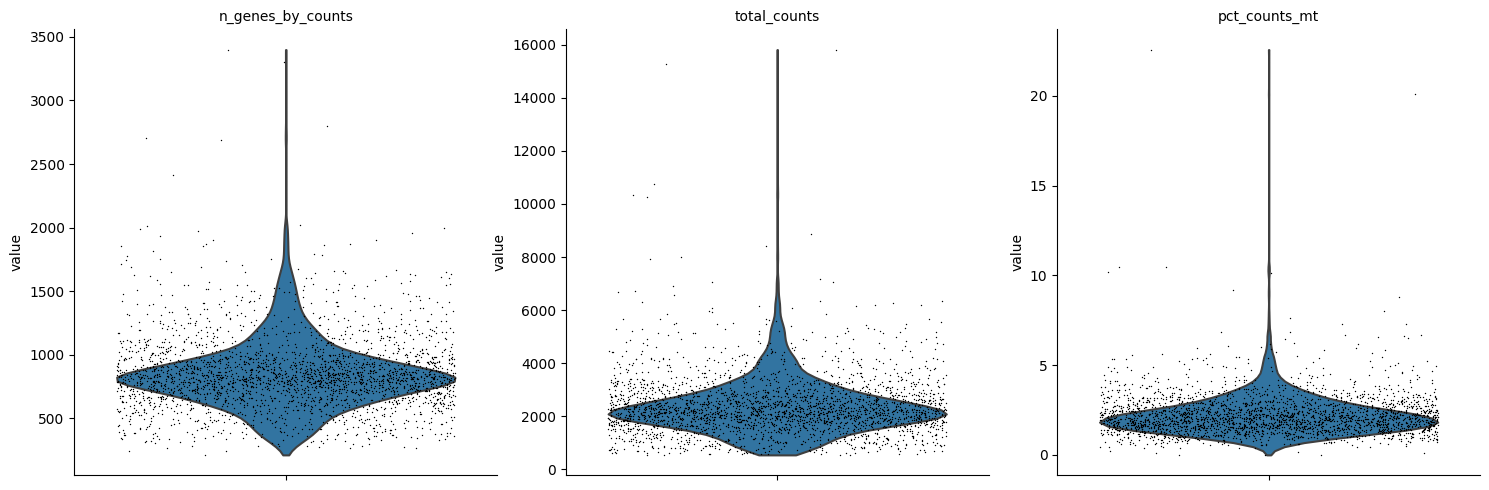

In [9]:
#a violin plot of the qc metrics
#n_genes_by_counts: Number of genes for which the counts are nonzero
#total_counts: Total counts for this cell
#pct_counts_mt: Fraction of counts in mitochondrial genes
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [10]:
#mitochondrial genes are expressed at higher levels in apoptotic, dying cells
#too many genes expressed: possible multiplets
#too few genes expressed: possible dead, low quality cells
print(f'Before filtering: {adata.X.shape}')

adata = adata[adata.obs.pct_counts_mt < 5, :]
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.n_genes_by_counts > 200, :]
print(f'After filtering: {adata.X.shape}')

Before filtering: (2700, 13714)
After filtering: (2638, 13714)


In [11]:
adata.X = sc.pp.normalize_total(adata, inplace=False, target_sum=10000)["X"]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=2000) 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:72: UserWarning: `flavor='pearson_residuals'` expects raw count data, but non-integers were found.
  warnings.warn(


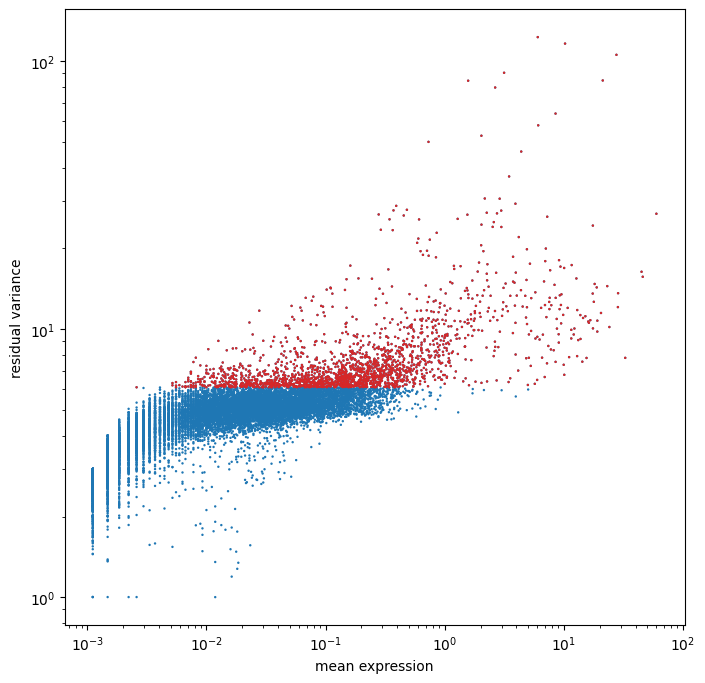

In [13]:
hvgs = adata.var["highly_variable"]

plt.figure(figsize=(8,8))
plt.scatter(adata.var["mean_counts"], adata.var["residual_variances"], s=3, edgecolor="none")
plt.scatter( 
        adata.var["mean_counts"][hvgs],
        adata.var["residual_variances"][hvgs],
        c="tab:red",
        label="selected genes",
        s=3,
        edgecolor="none",
)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("mean expression")
plt.ylabel("residual variance")

plt.show()

In [14]:
sc.pp.scale(adata.X)

array([[-5.7068359e-02, -3.3085335e-02, -3.8876239e-02, ...,
        -4.5372535e-02, -1.9046856e-01, -1.4999145e-01],
       [-5.7068359e-02, -3.3085335e-02, -3.8876239e-02, ...,
        -4.5372535e-02, -1.9046856e-01, -1.4999145e-01],
       [-5.7068359e-02, -3.3085335e-02, -3.8876239e-02, ...,
        -4.5372535e-02, -1.9046856e-01, -1.4999145e-01],
       ...,
       [-5.7068359e-02, -3.3085335e-02, -3.8876239e-02, ...,
        -4.5372535e-02, -1.9046856e-01, -1.4999145e-01],
       [-5.7068359e-02, -3.3085335e-02, -3.8876239e-02, ...,
         3.6252079e+01, -1.9046856e-01, -1.4999145e-01],
       [-5.7068359e-02, -3.3085335e-02, -3.8876239e-02, ...,
        -4.5372535e-02, -1.9046856e-01, -1.4999145e-01]], dtype=float32)

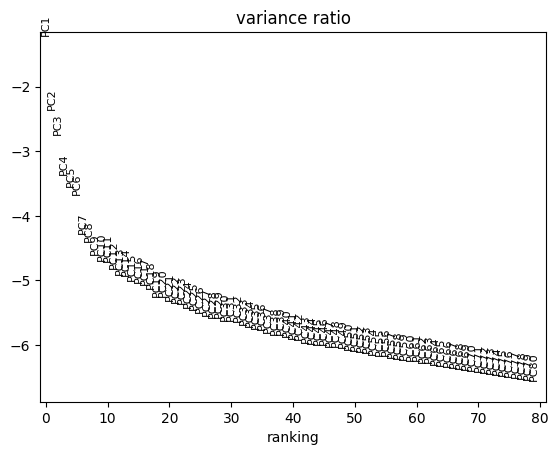

First 50 PCs explain 0.8105574250221252 of variance


In [15]:
X_pca = sc.pp.pca(adata, n_comps=80) 

sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 80) 

print(f"First 50 PCs explain {np.sum(adata.uns['pca']['variance_ratio'][:80])} of variance")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


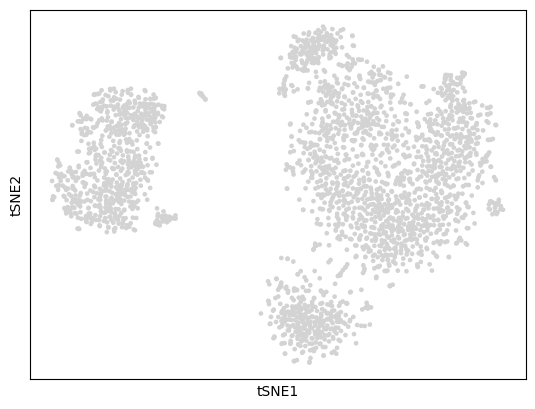

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


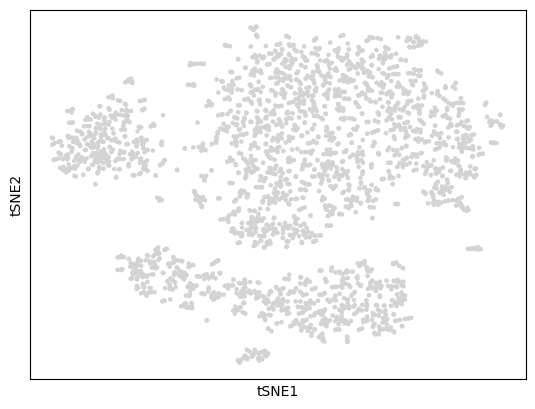

In [16]:
sc.tl.tsne(adata, use_rep="X_pca")
sc.pl.tsne(adata)


sc.tl.tsne(adata, use_rep="X_pca", perplexity=7)
sc.pl.tsne(adata)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


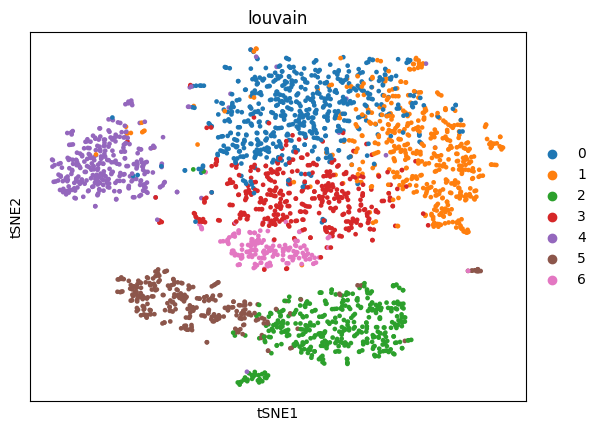

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


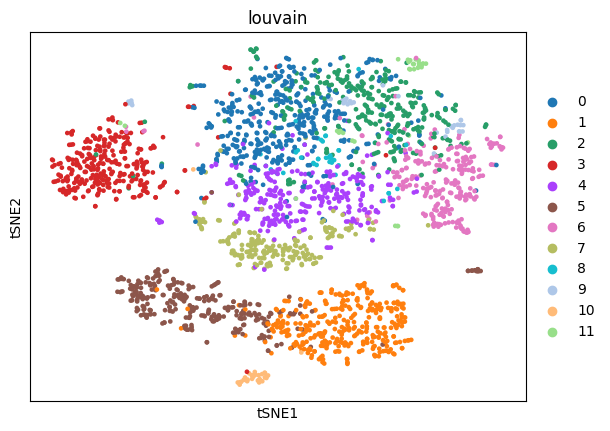

In [17]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=50)

sc.tl.louvain(adata)

sc.pl.tsne(adata, color=["louvain"], cmap="tab20")

sc.pp.neighbors(adata, n_neighbors=5, n_pcs=50)

sc.tl.louvain(adata)

sc.pl.tsne(adata, color=["louvain"], cmap="tab20")

#6 clusters w 50 neighbors, 13 clusters w 5 neighbors

In [191]:
import lsh
import importlib
importlib.reload(lsh)

<module 'lsh' from '/Users/koheisanno/Documents/School/COS521_Final/lsh.py'>

In [192]:
pca_data = adata.obsm['X_pca']

In [193]:
knn = lsh.KNN(pca_data.shape[1], 7, 20, 1)

In [194]:
knn.insert_points(pca_data)

In [195]:
test = knn.query(pca_data[0, :], 50)

In [167]:
distances = []
for point in pca_data:
    distances.append(np.linalg.norm(point - pca_data[0, :]))

distances = np.array(distances)
argsorted = np.argsort(distances)[:50]

closest_50 = pca_data[argsorted, :]

In [198]:
knn.points[test[0]]

array([-2.87586243e+02, -2.76800003e+01,  2.00532288e+02,  2.70512600e+01,
        2.40159760e+01,  1.48674831e+01,  1.88804760e+01, -3.38461723e+01,
       -6.35899353e+01,  4.16581154e+01,  3.49478760e+01,  8.25720310e+00,
       -1.38638372e+01, -2.67189827e+01, -1.99212723e+01,  4.17329941e+01,
        5.47445755e+01,  4.06725540e+01,  1.02926273e+01,  1.93398533e+01,
       -5.05572319e+00, -6.10679924e-01, -6.51742744e+00, -5.17678213e+00,
        3.44692421e+01,  5.04796028e+00,  4.65939293e+01, -4.08555870e+01,
       -1.18758135e+01, -1.26879864e+01,  7.57679062e+01,  1.16894999e+01,
        8.30635757e+01,  7.63821640e+01,  2.41889591e+01,  3.18263874e+01,
        4.86249313e+01,  8.11651917e+01,  4.18339729e+01, -7.98076477e+01,
        2.67662640e+01, -2.25862503e+01, -5.17840233e+01, -7.46273935e-01,
        6.03726101e+00,  3.56078696e+00,  4.90245552e+01,  1.35267913e+00,
       -1.08129282e+01, -2.36545029e+01,  3.14853039e+01,  1.83929939e+01,
       -6.82727432e+01, -

In [169]:
closest_50[5]

array([-1.0079536e+02, -3.9233936e+01, -1.2632013e+02,  6.4176514e+01,
        2.6159887e+01, -1.5732322e+01,  1.4803908e+01,  2.3653763e+01,
       -1.6958096e+01,  1.3984702e+01, -8.3364744e+00, -4.2421093e+00,
       -4.0449467e+01, -7.3032942e+00, -1.7130957e+01, -8.4309864e+00,
       -3.5815403e+01,  1.3859521e+00, -2.5757456e+01,  5.5774364e+00,
       -7.0223446e+00, -4.1627422e+01,  7.1078577e+00, -2.6735064e+01,
       -4.8009748e+00, -1.4518989e+01,  1.4006519e+00, -1.4983972e+01,
        1.0394571e+01, -1.0819286e+01, -5.4200001e+00,  6.5327315e+00,
       -2.2656193e+01, -1.1001441e+01, -1.1555081e+01, -1.4708881e+01,
       -2.2432520e+01, -1.9424772e+01,  5.7236805e+00, -1.0090904e+01,
        1.7607187e+01,  7.3609924e+00,  6.6193876e+00, -7.7995956e-02,
       -1.4784235e+01, -5.5734348e+00, -8.7360563e+00,  2.9743559e+00,
       -6.9109130e-01,  1.5993153e+01,  1.2353434e+01, -1.7181614e+01,
       -8.3862562e+00, -1.4135164e+00,  4.1751705e+01,  8.7059259e+00,
      

In [186]:
np.where(adata.obsp["connectivities"].todense()!=0)

(array([   0,    0,    0, ..., 2637, 2637, 2637]),
 array([ 970, 1043, 1504, ..., 1503, 2515, 2610]))

In [190]:
adata.obsp["connectivities"].todense()[2637, 1503]

0.40345654